In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy import optimize
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
import seaborn as sns

In [2]:
df = pd.read_csv("kursach_dataset.csv")

In [3]:
df['date'] = pd.to_datetime(df['DATE'])

In [4]:
df.drop("DATE", axis=1)

,GPDI,date
0,35.854,1947-01-01
1,34.505,1947-04-01
2,34.911,1947-07-01
3,43.250,1947-10-01
4,47.202,1948-01-01
...,...,...
302,4724.621,2022-07-01
303,4796.162,2022-10-01
304,4725.828,2023-01-01
305,4780.290,2023-04-01


In [5]:
df = df.reindex(columns=["date","GPDI"])
df[::-1]

,date,GPDI
306,2023-07-01,4922.073
305,2023-04-01,4780.290
304,2023-01-01,4725.828
303,2022-10-01,4796.162
302,2022-07-01,4724.621
...,...,...
4,1948-01-01,47.202
3,1947-10-01,43.250
2,1947-07-01,34.911
1,1947-04-01,34.505


In [6]:
df = df.groupby([pd.Grouper(key='date', freq='Q')], as_index=False).mean()
df[::-1]

,date,GPDI
306,2023-09-30,4922.073
305,2023-06-30,4780.290
304,2023-03-31,4725.828
303,2022-12-31,4796.162
302,2022-09-30,4724.621
...,...,...
4,1948-03-31,47.202
3,1947-12-31,43.250
2,1947-09-30,34.911
1,1947-06-30,34.505


<Axes: title={'center': 'GPDI per Quartal'}, xlabel='date'>

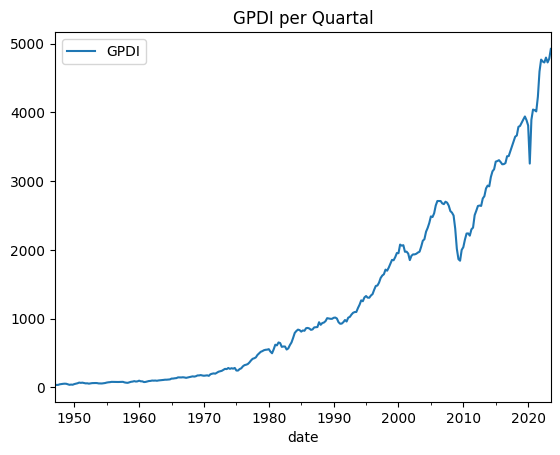

In [7]:
df.plot(x='date', y='GPDI', title = "GPDI per Quartal")

In [8]:
df["Темп роста"] = [None] + [ (df["GPDI"][i + 1] * 100) / df["GPDI"][i] for i in range(0 ,len(df["GPDI"]) - 1) ]
df["Темп прироста"] = df['Темп роста'] - 100
df[::-1]

,date,GPDI,Темп роста,Темп прироста
306,2023-09-30,4922.073,102.965992,2.965992
305,2023-06-30,4780.290,101.152433,1.152433
304,2023-03-31,4725.828,98.533536,-1.466464
303,2022-12-31,4796.162,101.514217,1.514217
302,2022-09-30,4724.621,99.695551,-0.304449
...,...,...,...,...
4,1948-03-31,47.202,109.137572,9.137572
3,1947-12-31,43.250,123.886454,23.886454
2,1947-09-30,34.911,101.176641,1.176641
1,1947-06-30,34.505,96.237519,-3.762481


In [9]:
temp_absolute = df.groupby([pd.Grouper(key='date', freq='5Y')], as_index=False).mean()
temp_absolute = temp_absolute[:-1]
temp_absolute

,date,GPDI,Темп роста,Темп прироста
0,1947-12-31,37.13000,107.100205,7.100205
1,1952-12-31,53.20155,102.257293,2.257293
2,1957-12-31,69.28540,100.895253,0.895253
3,1962-12-31,85.33130,101.687486,1.687486
4,1967-12-31,126.39370,102.275244,2.275244
5,1972-12-31,185.10050,102.533705,2.533705
6,1977-12-31,303.70840,103.013650,3.013650
7,1982-12-31,552.07770,101.474305,1.474305
8,1987-12-31,805.71660,102.830226,2.830226
9,1992-12-31,977.49245,100.595644,0.595644


<Axes: title={'center': 'Темп роста'}, xlabel='date'>

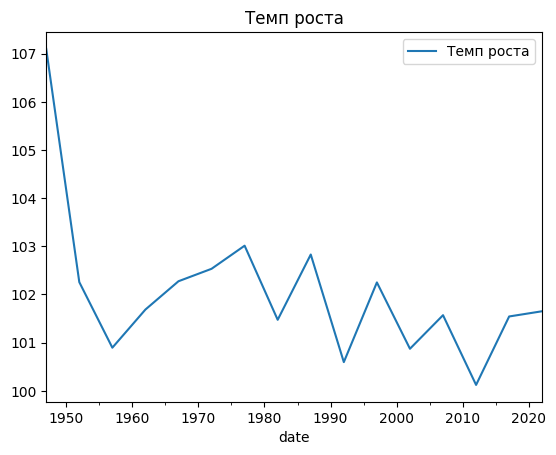

In [10]:
temp_absolute.plot(x='date', y='Темп роста', title = "Темп роста")

<Axes: title={'center': 'Темп прироста'}, xlabel='date'>

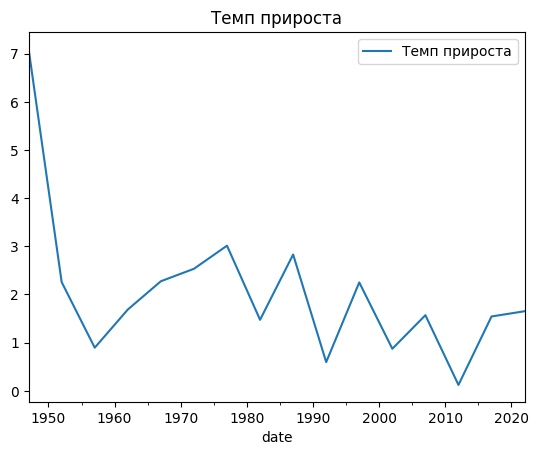

In [11]:
temp_absolute.plot(x='date', y='Темп прироста', title = "Темп прироста")

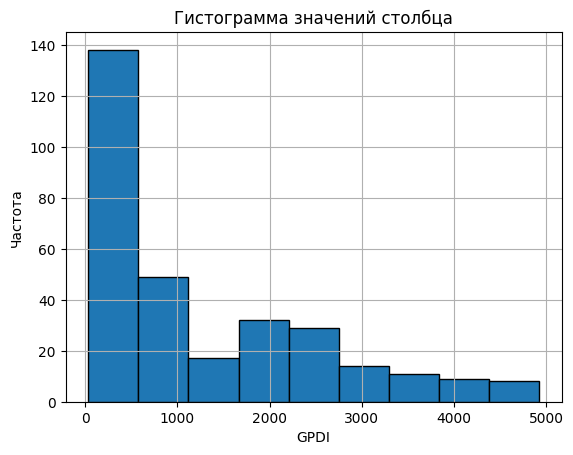

In [12]:
df['GPDI'].hist(bins=int(1+ 3.222 * np.log10(len(df["GPDI"]))), edgecolor='black')  # Вы можете настроить количество бинов (столбцов)
plt.title('Гистограмма значений столбца')
plt.xlabel('GPDI')
plt.ylabel('Частота')
plt.show()

In [13]:
# df_smooth = df.groupby([pd.Grouper(key='date', freq='4Y')], as_index=False).sum()
df_smooth = pd.DataFrame(columns=['GPDI_group'])
# Задайте размер группы
group_size = 16

# Итерируйтесь по группам
for i in range(0, len(df), group_size):
    group = df.iloc[i:i+group_size]['GPDI'].tolist()
    df_smooth = pd.concat([df_smooth, pd.DataFrame({'GPDI_group': [group]})], ignore_index=True)
    
df_smooth = df_smooth.drop(len(df_smooth) -1)
# Вычислите скользящее среднее

def calculate_smooth(arr):
    return [(arr[i - 1] + arr[i] + arr[i + 1]) / 3 for i in range(1, len(arr) - 1)]

# Добавьте новый столбец 'GPDI_smooth' с помощью метода apply
df_smooth['GPDI_smooth'] = df_smooth['GPDI_group'].apply(calculate_smooth)

def extrapolate(arr):
    tail = (arr[-1] - arr[0]) / len(arr)
    return [arr[0] - tail] + arr + [arr[-1] + tail]

df_smooth['GPDI_smooth'] = df_smooth['GPDI_smooth'].apply(extrapolate)





df_smooth
df_correct = df.copy()
df_correct = df_correct.drop(df.tail(3).index)
df_correct["GPDI_smooth"] = df_smooth['GPDI_smooth'].sum()
df_correct

,date,GPDI,Темп роста,Темп прироста,GPDI_smooth
0,1947-03-31,35.854,NaN,NaN,33.325643
1,1947-06-30,34.505,96.237519,-3.762481,35.090000
2,1947-09-30,34.911,101.176641,1.176641,37.555333
3,1947-12-31,43.250,123.886454,23.886454,41.787667
4,1948-03-31,47.202,109.137572,9.137572,46.929333
...,...,...,...,...,...
299,2021-12-31,4594.048,108.693496,8.693496,4529.136667
300,2022-03-31,4766.754,103.759343,3.759343,4699.950333
301,2022-06-30,4739.049,99.418787,-0.581213,4743.474667
302,2022-09-30,4724.621,99.695551,-0.304449,4753.277333


<Axes: xlabel='date'>

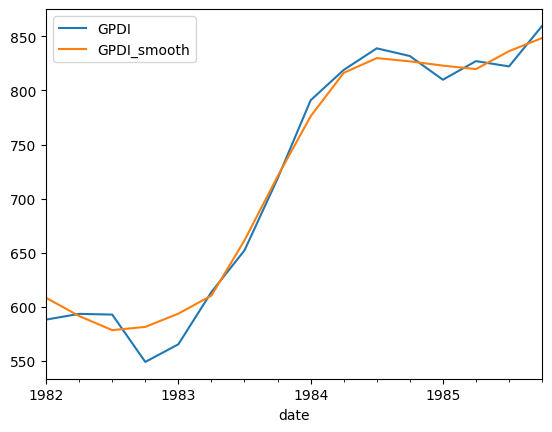

In [14]:
df_correct[['date','GPDI', 'GPDI_smooth']][140:156].plot(x='date', y=['GPDI', 'GPDI_smooth'])

In [15]:
df_correct['season'] = df_correct['GPDI']/df_correct['GPDI_smooth']
df_correct

,date,GPDI,Темп роста,Темп прироста,GPDI_smooth,season
0,1947-03-31,35.854,NaN,NaN,33.325643,1.075868
1,1947-06-30,34.505,96.237519,-3.762481,35.090000,0.983329
2,1947-09-30,34.911,101.176641,1.176641,37.555333,0.929588
3,1947-12-31,43.250,123.886454,23.886454,41.787667,1.034994
4,1948-03-31,47.202,109.137572,9.137572,46.929333,1.005810
...,...,...,...,...,...,...
299,2021-12-31,4594.048,108.693496,8.693496,4529.136667,1.014332
300,2022-03-31,4766.754,103.759343,3.759343,4699.950333,1.014214
301,2022-06-30,4739.049,99.418787,-0.581213,4743.474667,0.999067
302,2022-09-30,4724.621,99.695551,-0.304449,4753.277333,0.993971


In [16]:
groups = [df_correct["season"].iloc[i:i+16] for i in range(0, len(df_correct), 19)]

# Сложите каждую группу и поделите на 19
seasons_mean = [(group.sum() / 16) for group in groups] 
df_correct["season_mean"] = np.tile(seasons_mean, 19)
df_correct
# Определяются средние значения сезонных компонент за весь период:

,date,GPDI,Темп роста,Темп прироста,GPDI_smooth,season,season_mean
0,1947-03-31,35.854,NaN,NaN,33.325643,1.075868,1.005025
1,1947-06-30,34.505,96.237519,-3.762481,35.090000,0.983329,0.998011
2,1947-09-30,34.911,101.176641,1.176641,37.555333,0.929588,1.004899
3,1947-12-31,43.250,123.886454,23.886454,41.787667,1.034994,1.001028
4,1948-03-31,47.202,109.137572,9.137572,46.929333,1.005810,1.001838
...,...,...,...,...,...,...,...
299,2021-12-31,4594.048,108.693496,8.693496,4529.136667,1.014332,1.000401
300,2022-03-31,4766.754,103.759343,3.759343,4699.950333,1.014214,0.998363
301,2022-06-30,4739.049,99.418787,-0.581213,4743.474667,0.999067,1.000086
302,2022-09-30,4724.621,99.695551,-0.304449,4753.277333,0.993971,1.000386


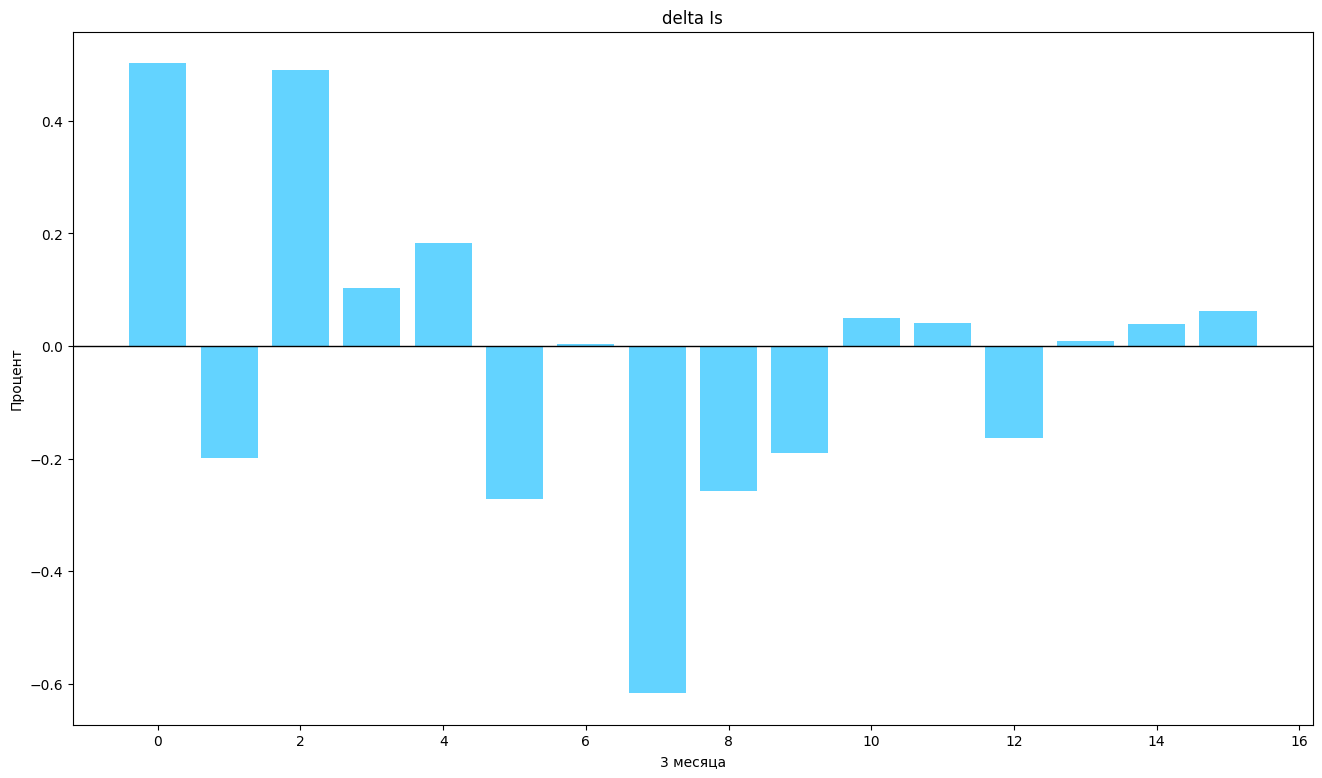

In [17]:
season_plot = [((x*100) - 100) for x in seasons_mean]

fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(np.arange(len(season_plot)), np.maximum(season_plot, 0), color='#63d3ff')
ax.bar(np.arange(len(season_plot)), np.minimum(season_plot, 0), color='#63d3ff')
ax.axhline(0, color='black', linewidth=1)
ax.set_xlabel('3 месяца')
ax.set_ylabel('Процент')
plt.title('delta Is')
plt.show()

In [18]:
df_correct['season'].sum()

304.0539629348667

In [19]:
# утсраненни сезонной компоненты
df_correct["correct_y"] = df_correct['GPDI'] / df_correct['season_mean']
df_correct

,date,GPDI,Темп роста,Темп прироста,GPDI_smooth,season,season_mean,correct_y
0,1947-03-31,35.854,NaN,NaN,33.325643,1.075868,1.005025,35.674738
1,1947-06-30,34.505,96.237519,-3.762481,35.090000,0.983329,0.998011,34.573773
2,1947-09-30,34.911,101.176641,1.176641,37.555333,0.929588,1.004899,34.740798
3,1947-12-31,43.250,123.886454,23.886454,41.787667,1.034994,1.001028,43.205604
4,1948-03-31,47.202,109.137572,9.137572,46.929333,1.005810,1.001838,47.115389
...,...,...,...,...,...,...,...,...
299,2021-12-31,4594.048,108.693496,8.693496,4529.136667,1.014332,1.000401,4592.206357
300,2022-03-31,4766.754,103.759343,3.759343,4699.950333,1.014214,0.998363,4774.570851
301,2022-06-30,4739.049,99.418787,-0.581213,4743.474667,0.999067,1.000086,4738.640609
302,2022-09-30,4724.621,99.695551,-0.304449,4753.277333,0.993971,1.000386,4722.800150


params:  126.34875081596724 1.0119408488187909
Covariance: 101355.59000540418
Corellation(Pirson): 0.9274020024322384


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24724\2272155639.py:9: RuntimeWarning: overflow encountered in power
  return a * np.power(b, x)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24724\2272155639.py:9: RuntimeWarning: overflow encountered in multiply
  return a * np.power(b, x)


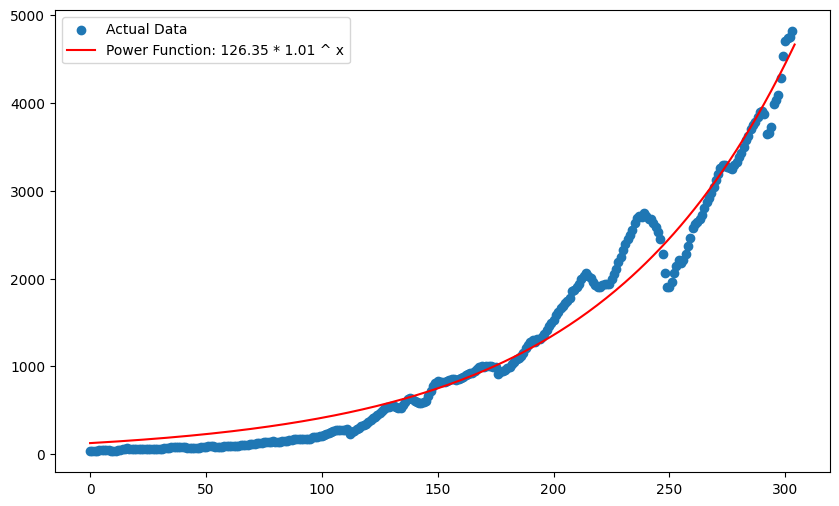

In [20]:
groups = df_correct["GPDI_smooth"]

Y = list(np.array(list(groups)).flatten())
l = len(Y)
X = np.array(range(l)).reshape(-1, 1)

# Power function to fit
def power_function(x, a, b):
    return a * np.power(b, x)

# Fit the power function to the data
params, covariance = curve_fit(power_function, X.flatten(), Y)
#a and b
print("params: ", *params)
covariance, stdx, stdy = 0, 0, 0
for i in range(len(Y)):
    covariance += (X.flatten()[i] - np.mean(X.flatten())) * (Y[i] - np.mean(Y))
    stdx += (X.flatten()[i] - np.mean(X.flatten()))**2
    stdy += (Y[i] - np.mean(Y))**2
stdx, stdy = stdx**0.5, stdy**0.5

print("Covariance:", covariance / len(Y))
corellation = covariance / (stdx * stdy)
print("Corellation(Pirson):", corellation)

# Generate values for the plot
X_plot = np.linspace(0, l, l)
Y_plot_power = power_function(X_plot, *params)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(X, Y, label='Actual Data')
plt.plot(X_plot, Y_plot_power, color='red', label=f'Power Function: {params[0]:.2f} * {params[1]:.2f} ^ x')
plt.legend()
# plt.savefig("./assets/models_comparasion.png")
plt.show()

In [21]:
res = power_function([300,301,302,303,304,305,306], *params)
# print(df_correct["season_mean"][:3])
predict = pd.concat([res[:4] * df_correct["season_mean"][-4:].reset_index(drop=True),res[4:] * df_correct["season_mean"][:3].reset_index(drop=True)], ignore_index=True) 
predict
# df["GPDI"][-3:]

0    4440.149089
1    4500.924314
2    4556.032546
3    4611.492711
4    4687.124423
5    4709.990630
6    4799.128941
Name: season_mean, dtype: float64

In [22]:
y_sales_2023 = df["GPDI"][-7:].reset_index(drop=True)
y_sales_2023_mean = np.mean(y_sales_2023)
delta = np.array(y_sales_2023) - y_sales_2023_mean
E = np.array(y_sales_2023) / predict
R_sqared = 1 - np.dot(E, E.T) / np.dot(delta, delta.T)
print(f"R: {R_sqared}")
print(f"r xy: {np.sqrt(R_sqared)}")

R: 0.9997343528646055
r xy: 0.9998671676100809


In [23]:
# тут сделаем критерий Фишера
n = 7
m = 1
y_predict_2023_diff_y_mean = predict - y_sales_2023_mean
s_squared_factor = np.sum(np.power(y_predict_2023_diff_y_mean, 2)) / m # SSR / m
s_sqared_error = np.sum(np.power((y_sales_2023 - predict), 2)) / (n - m - 1) # SSE / (n - m - 1)


F = s_squared_factor / s_sqared_error

print(f"F: {F}")

alpha = 0.1
#degree of freedom
df_num = m
df_denum = n - m - 1
f_critical = st.f.ppf(1 - alpha, df_num, df_denum)


P = 1 - st.f.cdf(F, df_num, df_denum)
print(f"P: {P}")
print(f"Critical: {f_critical}")

F: 5.740683122483435
P: 0.06192844930669161
Critical: 4.060419946872068


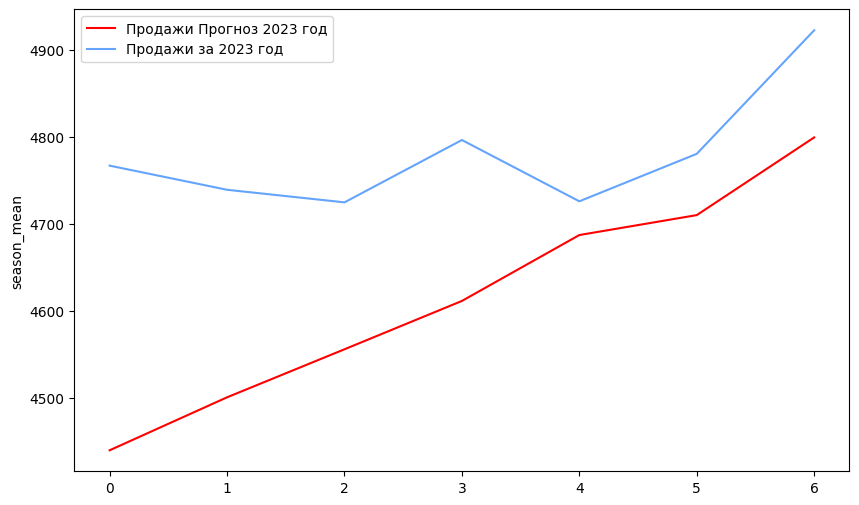

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
y_sales_2023 = df['GPDI'][-7:]
y_predict_2023 = predict
sns.lineplot(x=range(len(y_predict_2023)), y=y_predict_2023, color='red', label='Продажи Прогноз 2023 год', ax=ax)
sns.lineplot(x=range(len(y_sales_2023)), y=y_sales_2023, color='#65a4fc', label='Продажи за 2023 год', ax=ax)
plt.show()

In [25]:
T = st.t.ppf(1 - alpha/2, 9)
tb = np.sqrt(F)
print(T)

b = params[1]
mb = b / tb
print("mb", mb)
delta = T * mb
print("delta", delta)
print(f"interval: [{round(b - delta, 2)}; {round(b + delta, 2)}]")

1.8331129326536333
mb 0.4223508181408557
delta 0.7742167468508453
interval: [0.24; 1.79]
